In [16]:
import pandas as pd
import plotnine
plotnine.options.figure_size = (12, 10)

# Tidsserier i pandas

Data med tidsinformation indeholder en række udfordringer ift. både visualisering og databehandling.

- Hvordan forstår Python tid og datoer?
- Hvilken tidsenhed skal der arbejdes med?
- Hvordan undgås for mange unikke værdier i tidsvariablen?

I det følgende ses nærmere på, hvordan man kan arbejde med tidsinformation i Python. Som eksempeldata arbejdes med aktiekursdata for Maersk (A.P. Møller - Mærsk A/S).

Senere kombinerer vi dette med Google Trends data om søgninger på "Maersk".

**Datasæt A: Aktiekurs for Maersk B**

Datasættet "maerskb_price-history_01072021-01092021.csv" indeholder kursinformation for aktien "Maersk B". Data indeholder kursinformation for hver halve time for perioden 1/7/2021-1/9/2021; herunder kurs ved åbning, luk, laveste kurs, højeste kurs samt volumen.

**Datasæt B: Google Trends data for Maersk**

Datasættet "google-trends_maersk_01072021-01092021.csv" indeholder antal søgninger på Google på "Maersk" i perioden 1/7/2021-1/9/2021.

In [2]:
import pandas as pd

maersk = pd.read_csv("https://github.com/CALDISS-AAU/course_ddf/raw/master/datasets/maerskb_price-history_01072021-01092021.csv")
maersk.head()

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High,Volume
0,2021-09-01 10:30:00,2021-09-01 10:30:00,18040,-5.0,-0.000277,18055,18015,18080,709
1,2021-09-01 10:00:00,2021-09-01 10:00:00,18045,35.0,0.001943,18025,17985,18120,1144
2,2021-09-01 09:30:00,2021-09-01 09:30:00,18010,140.0,0.007834,17975,17920,18080,2030
3,2021-08-31 17:00:00,2021-08-31 17:00:00,17870,80.0,0.004497,17790,17500,17870,55188
4,2021-08-31 16:30:00,2021-08-31 16:30:00,17790,-45.0,-0.002523,17835,17790,17880,2051


In [3]:
maersk['Local Time'].head()

0    2021-09-01 10:30:00
1    2021-09-01 10:00:00
2    2021-09-01 09:30:00
3    2021-08-31 17:00:00
4    2021-08-31 16:30:00
Name: Local Time, dtype: object

## Linjeplots

Tidsserier kan med fordel visualiseres med linjeplots. Linjeplots dannes i `plotnine` med `geom_line`. `plotnine` og `pandas` kan dog give bøvl med datoer og tid, hvis ikke data er korrekt formateret som tid:

C:\Users\kgk\.conda\envs\tm\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


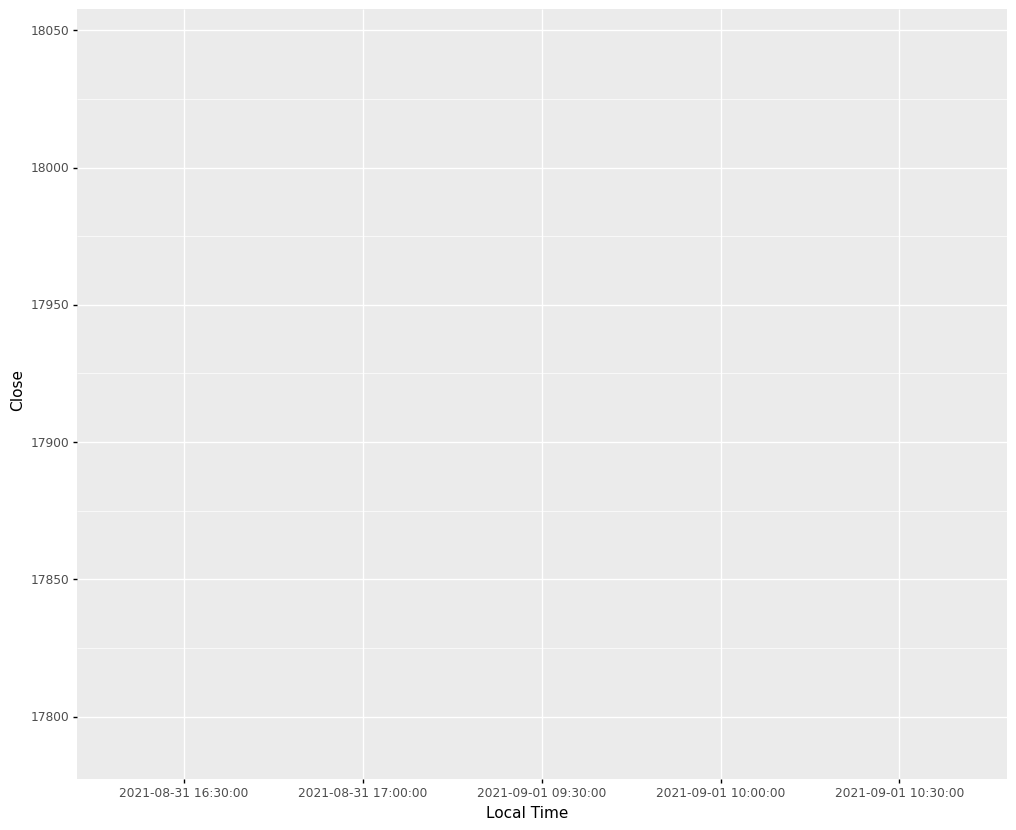

<ggplot: (-9223371896969859480)>

In [19]:
from plotnine import ggplot, aes, geom_line

(ggplot(data = maersk.head(), mapping = aes(x = 'Local Time', y = 'Close'))
 + geom_line())

## Konvertering til datetime

Data indeholder tydeligvis tidsinformation i kolonnerne "Local Date" og "Local Time". Python kan bare ikke genkende, at det er dette format:

In [20]:
maersk['Local Time'].dtypes

dtype('O')

For at formatere en kolonne til datoformat, bruges `astype('datetime64')`. Denne konverterer kolonnen til den rette datotype.

In [21]:
maersk['Local Time'] = maersk['Local Time'].astype('datetime64')

Da Python nu kan gende kolonnen som tid, kan linjeplottet laves:

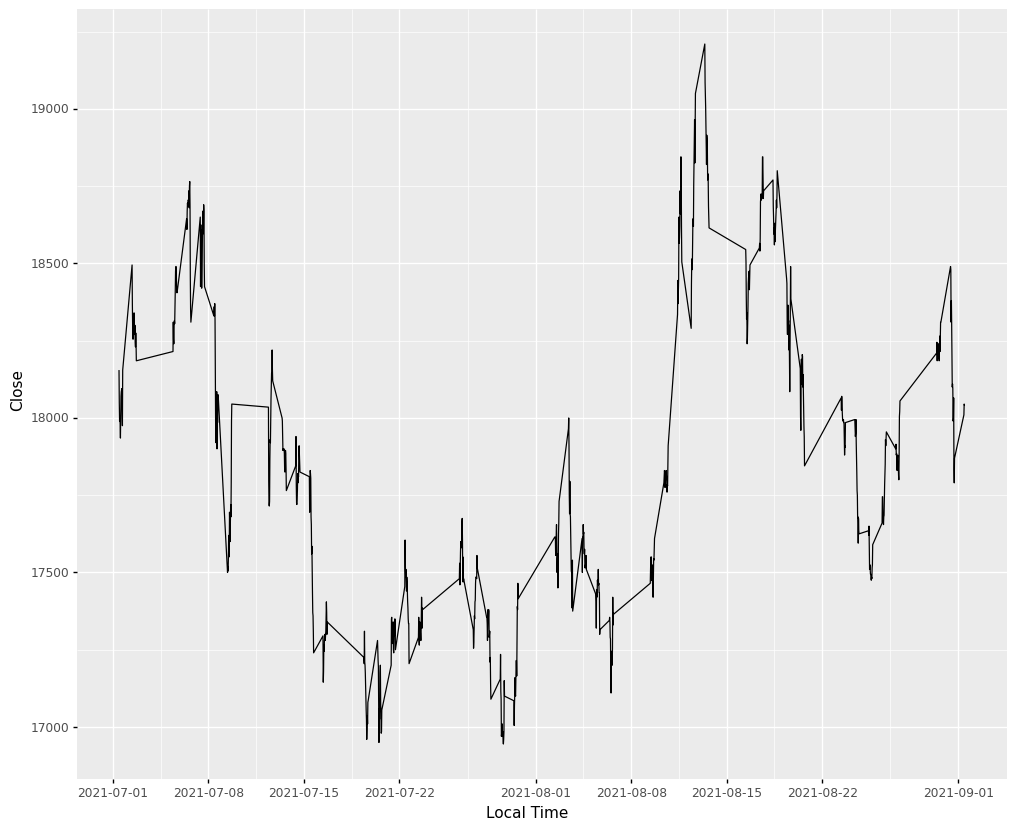

<ggplot: (-9223371896968565184)>

In [22]:
(ggplot(data = maersk, mapping = aes(x = 'Local Time', y = 'Close'))
 + geom_line())

## Håndtering af tidsdata

Pandas indeholder en lang række series metoder til at arbejde med datoer og tid ("datetime"). Disse er alle under `.dt`. 

Man er i arbejdet med tidsserier ofte i situationer, hvor man kan have brug for at reducere detaljegraden. Fx er det vanskeligt i det nuværende format at gennemskue hvilken måned, der blev handlet flest aktier. Samtidig kan en visualiseirng også med fordel simplificeres for at gøre den rarere at se på.

Med de forskellige `.dt` metoder, kan man hurtigt danne nye kolonner baseret på en anden frekvens (fx timer, dage, uger, måneder, år). Data kan derefter grupperes og summeres efter disse kolonner. 

Eksempler på `.dt` metoder:

- `dt.year`: År
- `dt.month`: Måned (i tal)
- `dt.day`: Dag
- `dt.hour`: Timetal
- `dt.date`: Dato
- `dt.isocalendar().week`: Ugenummer
- `dt.weekday`: Ugedag (i tal)

Man kunne fx undersøge, hvilken dag på ugen, der bliver handlet flest aktier, ved først at lave en kolonne for ugedagen, gruppere på ugedag, danne middel for volumen og visualisere:

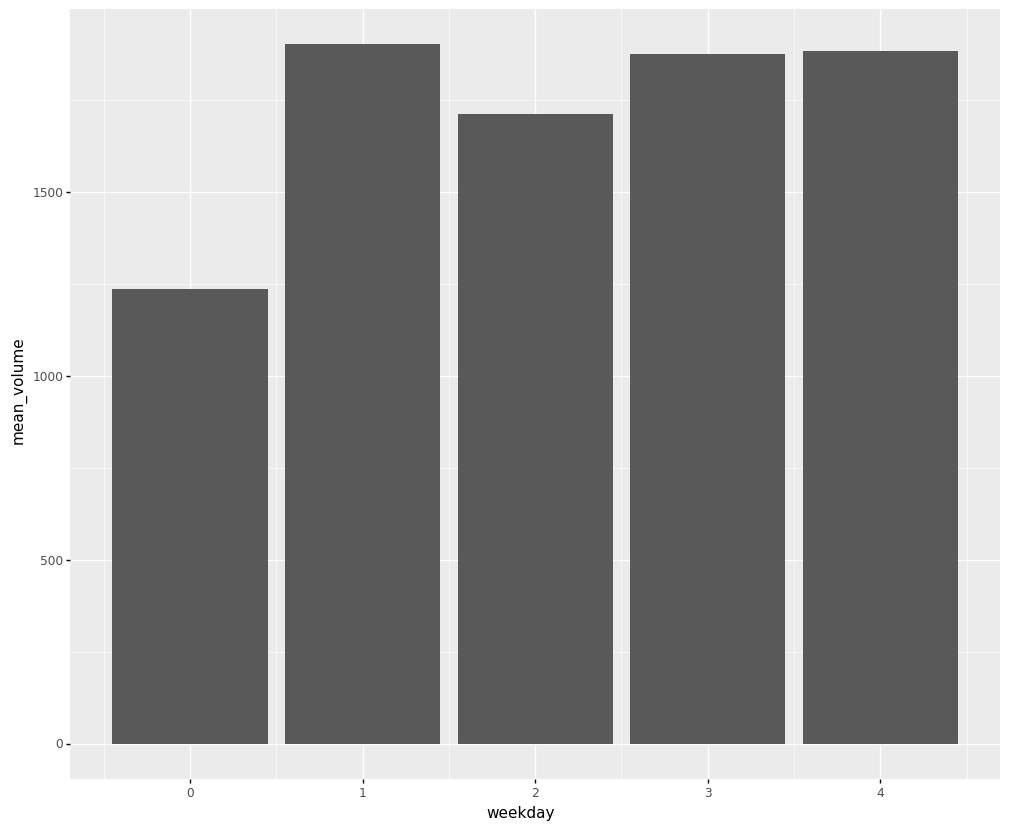

<ggplot: (-9223371896968716804)>

In [53]:
from plotnine import geom_bar

maersk['weekday'] = maersk['Local Time'].dt.weekday
maersk_weektrade = maersk.groupby('weekday')['Volume'].mean().to_frame(name = 'mean_volume').reset_index()

(ggplot(data = maersk_weektrade, mapping = aes(x = 'weekday', y = 'mean_volume'))
 + geom_bar(stat = 'identity')) # stat = identity fortæller at data skal bruges, som det er 

Man kunne også bruge metoderne til at simplificere grafen over lukkekurser en smule:

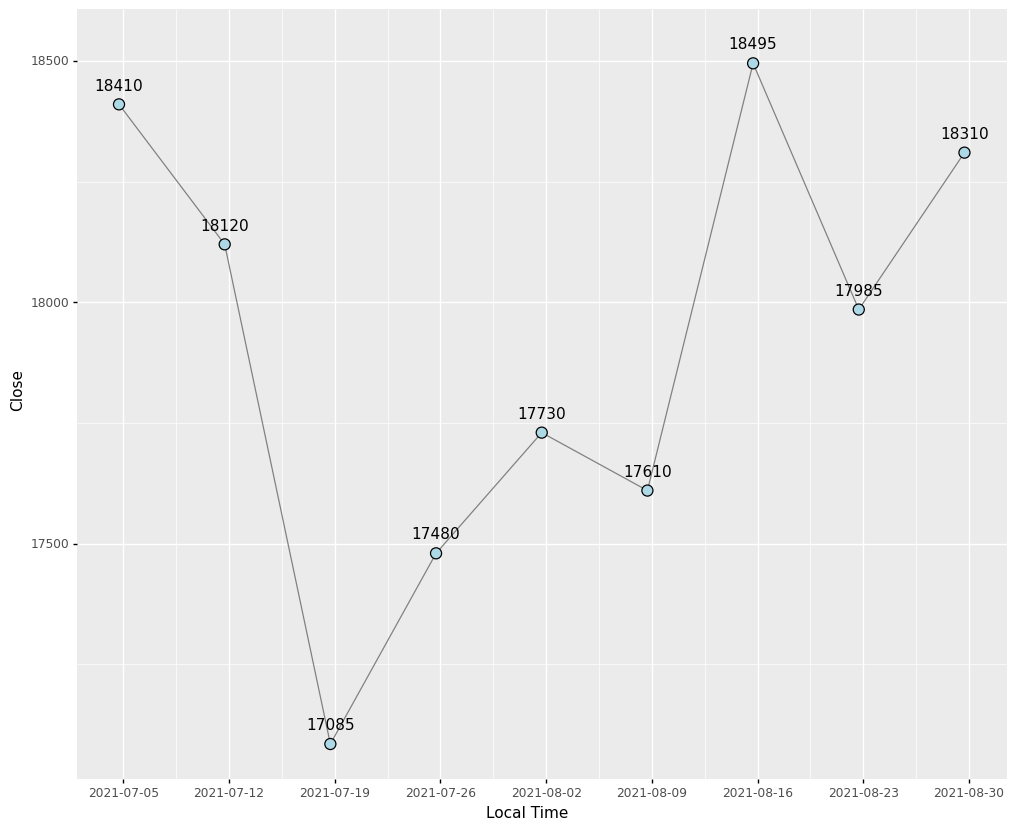

<ggplot: (-9223371896968652484)>

In [54]:
from plotnine import geom_line, geom_point, geom_text, scale_x_date

maersk['date'] = maersk['Local Time'].dt.date
maersk_weekly = maersk.loc[maersk.groupby('date')['Local Time'].idxmax(), :]
maersk_weekly = maersk_weekly.loc[maersk_weekly['weekday'] == 0]

(ggplot(data = maersk_weekly, mapping = aes(x = 'Local Time', y = 'Close'))
 + geom_line(color = "grey")
 + geom_point(size = 4, color = "black", fill = "lightblue")
 + geom_text(mapping = aes(label = 'Close'), nudge_y = 40)
 + scale_x_date(date_breaks = "1 week", labels = maersk_weekly['date'].unique()))

## Kombiner data på tid

Fordi man nemt kan ændre tidsenheden, kan man kombinere data ud fra samme tidsenhed. Som eksempel, kunne vi forsøge at sammenlægge ovenstående med Google-søgninger på Maersk i samme periode:

In [55]:
import pandas as pd

maersk_trends = pd.read_csv("https://github.com/CALDISS-AAU/course_ddf/raw/master/datasets/google-trends_maersk_01072021-01092021.csv")
maersk_trends = maersk_trends.rename(columns = {'Maersk': 'n_searches'})

Google Trends data er på dagsniveau:

In [56]:
maersk_trends.head()

,Dag,n_searches
0,2021-07-01,85
1,2021-07-02,76
2,2021-07-03,38
3,2021-07-04,42
4,2021-07-05,77


Ligesom med aktiekursdata, skal kolonnen kodes som dato

In [57]:
maersk_trends.dtypes

Dag           object
n_searches     int64
dtype: object

In [58]:
maersk_trends['Dag'] = maersk_trends['Dag'].astype('datetime64')

I dette tilfælde har datoerne mellem de to datasæt samme format, men man kan nemt komme ud for, at formaterne er forskellige. Som eksempel kodes trends-data til dag-måned-år format med `dt.strftime()`:

In [59]:
maersk_trends['Dag'] = maersk_trends['Dag'].dt.strftime('%d-%m-%Y')
maersk_trends['Dag'].head()

0    01-07-2021
1    02-07-2021
2    03-07-2021
3    04-07-2021
4    05-07-2021
Name: Dag, dtype: object

Forsøges man at merge data, passer værdier nu ikke:

In [60]:
maersk_st = pd.merge(maersk_weekly, maersk_trends, left_on = 'date', right_on = 'Dag')
maersk_st

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High,Volume,weekday,date,Dag,n_searches


Konverteres dato i andet datasæt til samme format, kan det lade sig gøre:

In [61]:
maersk_weekly['date'] = maersk_weekly['Local Time'].dt.strftime('%d-%m-%Y')
maersk_st = pd.merge(maersk_weekly, maersk_trends, left_on = 'date', right_on = 'Dag')
maersk_st.head()

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High,Volume,weekday,date,Dag,n_searches
0,2021-07-05 17:00:00,2021-07-05 17:00:00,18410,5.0,0.000272,18410,18355,18420,3001,0,05-07-2021,05-07-2021,77
1,2021-07-12 17:00:00,2021-07-12 17:00:00,18120,-35.0,-0.001928,18165,18120,18215,5984,0,12-07-2021,12-07-2021,89
2,2021-07-19 17:00:00,2021-07-19 17:00:00,17085,5.0,0.000293,17075,17035,17190,8754,0,19-07-2021,19-07-2021,83
3,2021-07-26 17:00:00,2021-07-26 17:00:00,17480,10.0,0.000572,17470,17455,17545,4880,0,26-07-2021,26-07-2021,76
4,2021-08-02 17:00:00,2021-08-02 17:00:00,17730,70.0,0.003964,17665,17640,17795,8310,0,02-08-2021,02-08-2021,94


Data indeholder nu både aktiekurser og trenddata. Dette kan nu kombineres i en graf.

`plotnine`/`ggplot` tillader ikke forskellige y-akser, så først normaliseres data (laveste kurs/antal søgning i perioden = 0, højeste = 100).

In [103]:
maersk_close = maersk_st.copy()
maersk_close['Measure'] = "Stock price"
maersk_close['norm_measure'] = maersk_close['Close'].apply(lambda x: (x - maersk_close['Close'].min()) / (maersk_close['Close'].max() - maersk_close['Close'].min()))
maersk_close['true_measure'] = maersk_close['Close']

maersk_trends = maersk_st.copy()
maersk_trends['Measure'] = "Google searches"
maersk_trends['norm_measure'] = maersk_trends['n_searches'].apply(lambda x: (x - maersk_trends['n_searches'].min()) / (maersk_trends['n_searches'].max() - maersk_trends['n_searches'].min()))
maersk_trends['true_measure'] = maersk_trends['n_searches']

maersk_conc = pd.concat([maersk_close, maersk_trends])
maersk_conc.head()

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High,Volume,weekday,...,Dag,n_searches,close_norm,search_norm,norm_close,norm_search,id,Measure,norm_measure,true_measure
0,2021-07-05 17:00:00,2021-07-05 17:00:00,18410,5.0,0.000272,18410,18355,18420,3001,0,...,05-07-2021,77,0.939716,0.055556,0.939716,0.055556,0,Stock price,0.939716,18410
1,2021-07-12 17:00:00,2021-07-12 17:00:00,18120,-35.0,-0.001928,18165,18120,18215,5984,0,...,12-07-2021,89,0.734043,0.722222,0.734043,0.722222,1,Stock price,0.734043,18120
2,2021-07-19 17:00:00,2021-07-19 17:00:00,17085,5.0,0.000293,17075,17035,17190,8754,0,...,19-07-2021,83,0.000000,0.388889,0.000000,0.388889,2,Stock price,0.000000,17085
3,2021-07-26 17:00:00,2021-07-26 17:00:00,17480,10.0,0.000572,17470,17455,17545,4880,0,...,26-07-2021,76,0.280142,0.000000,0.280142,0.000000,3,Stock price,0.280142,17480
4,2021-08-02 17:00:00,2021-08-02 17:00:00,17730,70.0,0.003964,17665,17640,17795,8310,0,...,02-08-2021,94,0.457447,1.000000,0.457447,1.000000,4,Stock price,0.457447,17730


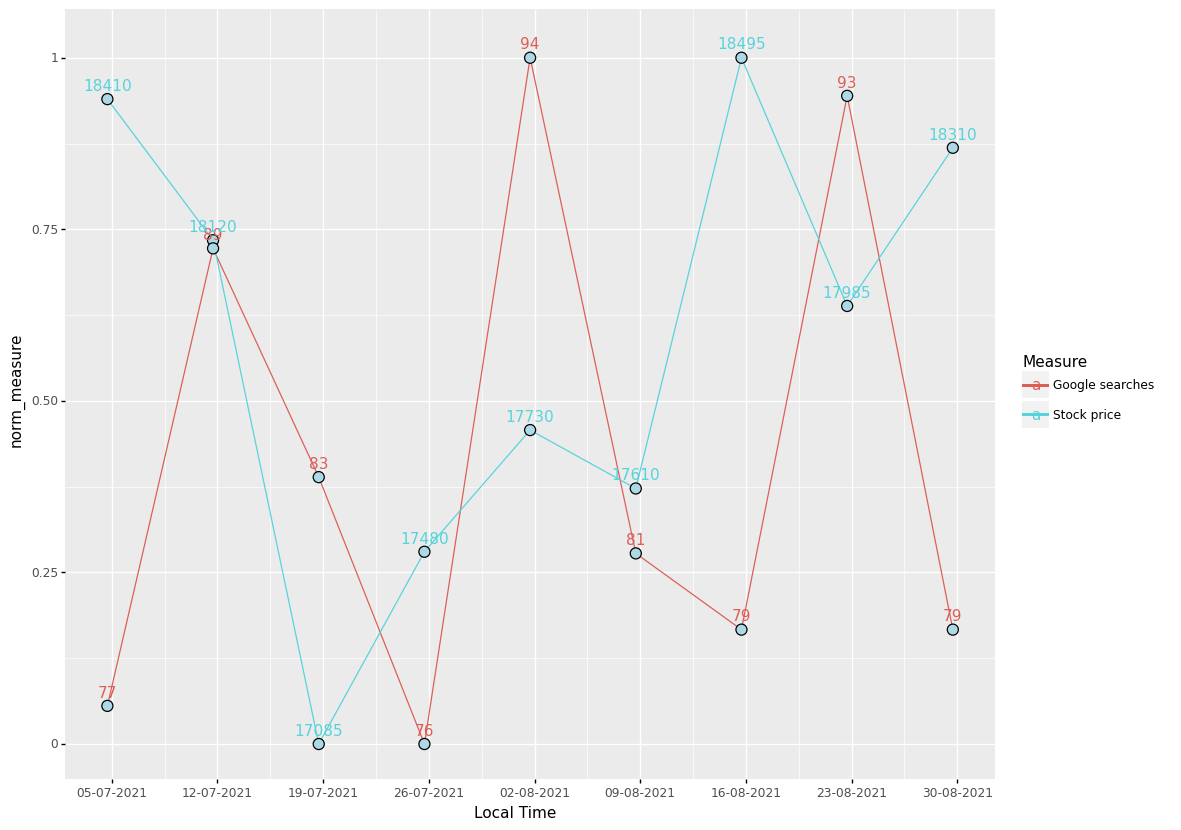

<ggplot: (-9223371896968221296)>

In [104]:
(ggplot(data = maersk_conc, mapping = aes(x = 'Local Time', y = 'norm_measure', colour = 'Measure'))
 + geom_line()
 + geom_point(size = 4, color = "black", fill = "lightblue")
 + geom_text(mapping = aes(label = 'true_measure'), nudge_y = 0.02)
 + scale_x_date(date_breaks = "1 week", labels = maersk_weekly['date'].unique()))

# ØVELSE 4: TIDSSERIER

Vi ønsker at udforske kommentaraktivitet over tid i datasættet [reddit_rdenmark-comments_01032021-08032021_long.csv](https://raw.githubusercontent.com/CALDISS-AAU/course_ddf/master/datasets/reddit_rdenmark-comments_01032021-08032021_long.csv).

Lav en passende visualisering til at udforske dette.

**Hints:**
- Tidspunkt for kommentar er i "comment_created_utc". Denne er dog angivet som UTC timestamp. I kan konvertere til datetime med: `reddit['comment_created_utc'] = pd.to_datetime(reddit['comment_created_utc'], unit='s')`
- Tænk i groupbys: hvilken passende tidsenhed giver mening at opsummere data efter?